# t-SNE

**t-Distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique used primarily for visualizing high-dimensional data in a lower-dimensional space (typically 2D or 3D).** 

### Why Use t-SNE?

1. Human Interpretation: Helps visualize high-dimensional data by projecting it into 2D/3D while preserving important structure.
2. Captures Complex Relationships: Unlike PCA, which is a linear technique, t-SNE preserves local similarities and can identify clusters that are not linearly separable.
3. Common in Deep Learning & NLP: Used to analyze embeddings like Word2Vec, image features, and latent representations from neural networks.

### Analogy: Cities on a Map

Imagine you have a list of cities and the distances between them. Your goal is to create a 2D map that preserves their relative distances as accurately as possible.

* Far Away Cities Stay Far: If two cities are far apart in reality, they should be far apart on the map.
* Nearby Cities Stay Close: If two cities are close in reality, they should be close on the map.
* Small Local Distortions Are Acceptable: The absolute distances may not be perfect, but local relationships should be preserved.
* This is exactly what t-SNE does with high-dimensional data!

### t-SNE consists of two main steps:

* Step 1: Compute Pairwise Similarities in High Dimensions
Instead of using raw distances, t-SNE models the probability that two points are neighbors.
It uses a Gaussian (normal) distribution to measure similarity in the high-dimensional space.
* Step 2: Compute Pairwise Similarities in Low Dimensions
In the lower-dimensional space, t-SNE uses a t-distribution instead of a Gaussian.
The t-distribution has fatter tails, which helps to keep distant points far apart.
* Step 3: Minimize the Difference Between the Two Distributions

t-SNE tries to make the probability distribution in the low-dimensional space as close as possible to the high-dimensional probability distribution.

It does this by using gradient descent to iteratively update the positions of points.

### 4. Comparison: t-SNE vs PCA

| Feature          | PCA               | t-SNE              |
|------------------|-------------------|--------------------|
| **Type**         | Linear            | Nonlinear          |
| **Preserves**    | Global structure  | Local structure    |
| **Speed**        | Fast              | Slower             |
| **Use Case**     | Feature extraction| Data visualization |
| **Clusters**    | May mix up clusters| Preserves clusters better |

#### The Mathematics Behind t-SNE

At its core, t-SNE preserves local relationships by ensuring that points that are close in high-dimensional space remain close in lower dimensions.

#### 1.1. Step 1: Compute Pairwise Similarities in High-Dimensional Space

We define a similarity score between two points $x_i$ and $x_j$ in the high-dimensional space using a Gaussian distribution:

$$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$

- $p_{j|i}$ represents how similar $x_j$ is to $x_i$.
- $\sigma_i$ (standard deviation) controls the spread of the Gaussian around $x_i$.
- The denominator ensures that all similarities sum to 1 (probability distribution).

The final similarity score between two points is symmetric:

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$

where $N$ is the total number of points.

#### 1.2. Step 2: Compute Pairwise Similarities in Low-Dimensional Space

Now, we model the probability that two points $y_i$ and $y_j$ (mapped in lower-dimensional space) are close using a t-distribution instead of a Gaussian:

$$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$

**Why t-distribution?**

- It has fatter tails, meaning it prevents distant points from collapsing together.
- This helps maintain global structure better than a normal Gaussian.

#### 1.3. Step 3: Minimize the KL-Divergence (Optimization)

To make the low-dimensional distribution $q_{ij}$ match the high-dimensional distribution $p_{ij}$, we minimize the Kullback-Leibler (KL) Divergence:

$$KL(P||Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

- KL-Divergence is a measure of how different two probability distributions are.
- A lower KL value means the high-dimensional and low-dimensional distributions are similar.
- We optimize this using gradient descent to adjust the positions of the points in the 2D or 3D space.

### 2. Key Hyperparameters of t-SNE

#### 2.1. Perplexity (Most Important Hyperparameter)

- **What it does**: Controls the balance between local and global structure.
- **Analogy**: Think of perplexity as how many neighbors each point should consider.
- **Typical values**: 5 to 50 (default: 30).
- **Effect**:
  - Low perplexity (5-10) → Focuses on very local structure (small clusters).
  - High perplexity (40-50) → Preserves more of the global structure.
  - Too high → The method may fail to capture meaningful local clusters.

#### 2.2. Learning Rate

- Determines how much the position of a point is adjusted at each step.
- Too low → Convergence is slow.
- Too high → The embedding might become unstable.

#### 2.3. Number of Iterations

- More iterations improve the mapping, but diminishing returns occur after a certain point.
- Rule of thumb: 1000-5000 iterations are usually enough.

#### 2.4. Initialization

- **Random**: Positions are initialized randomly.
- **PCA Initialization**: Starts with PCA-reduced points, leading to faster convergence.

### 3. Comparison with Other Dimensionality Reduction Techniques

| Technique | Preserves | Handles Nonlinear Structure? | Common Use Case |
|-----------|-----------|------------------------------|-----------------|
| PCA | Global structure | ❌ No | Feature extraction, data compression |
| LDA | Class separation | ❌ No | Supervised dimensionality reduction |
| t-SNE | Local structure | ✅ Yes | Visualization of high-dimensional data |
| UMAP | Local + global structure | ✅ Yes | Faster, alternative to t-SNE |

# Code:

**Steps for Implementing t-SNE**

1. Compute Pairwise Similarities in High-Dimensional Space (Using Gaussian Distribution)
2. Compute Pairwise Similarities in Low-Dimensional Space (Using t-Distribution)
3. Compute KL-Divergence and Its Gradient
4. Optimize via Gradient Descent
5. Return the Final Low-Dimensional Representation

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [3]:
# Compute Pairwise Similarities in High-Dimensional Space

def compute_high_dim_affinities(X, perplexity=30.0):
    """Compute pairwise similarities using a Gaussian distribution."""
    (n, d) = X.shape
    distances = squareform(pdist(X, "euclidean")) ** 2
    P = np.zeros((n, n))
    
    for i in range(n):
        betas = 1.0  # Inverse variance (1/σ²)
        min_beta, max_beta = None, None
        target_perplexity = np.log(perplexity)

        # Binary search for beta to match perplexity
        for _ in range(50):  
            Pi = np.exp(-distances[i] * betas)
            Pi[i] = 0  # Avoid self-affinity
            sum_Pi = np.sum(Pi)
            H = np.log(sum_Pi) + betas * np.sum(distances[i] * Pi) / sum_Pi
            Pi /= sum_Pi

            if H > target_perplexity:
                min_beta = betas
                betas = (betas + max_beta) / 2 if max_beta is not None else betas * 2
            else:
                max_beta = betas
                betas = (betas + min_beta) / 2 if min_beta is not None else betas / 2

        P[i] = Pi

    P = (P + P.T) / (2 * n)  # Symmetrize
    return P

In [4]:
# Compute Pairwise Similarities in Low-Dimensional Space

def compute_low_dim_affinities(Y):
    """Compute affinities using a t-distribution."""
    distances = squareform(pdist(Y, "euclidean")) ** 2
    Q = (1 + distances) ** -1
    np.fill_diagonal(Q, 0)  # No self-similarity
    Q /= np.sum(Q)
    return Q

In [5]:
# Compute KL-Divergence and Its Gradient

def compute_gradient(P, Q, Y):
    """Compute gradient of KL-divergence for optimization."""
    pq_diff = P - Q  # Difference between high-dim and low-dim affinities
    distances = squareform(pdist(Y, "euclidean")) ** 2
    grad = np.zeros_like(Y)

    for i in range(Y.shape[0]):
        weighted_sum = np.sum(pq_diff[:, i][:, np.newaxis] * (Y[i] - Y), axis=0)
        grad[i] = 4 * weighted_sum

    return grad

In [6]:
#  Define the t-SNE Class (OOP Approach)

class TSNE:
    def __init__(self, learning_rate=200, perplexity=30, n_iter=1000):
        self.learning_rate = learning_rate
        self.perplexity = perplexity
        self.n_iter = n_iter

    def fit_transform(self, X):
        """Perform t-SNE on input data X."""
        n, d = X.shape
        P = compute_high_dim_affinities(X, self.perplexity)
        Y = np.random.randn(n, 2) * 0.0001  # Small random initialization

        for i in range(self.n_iter):
            Q = compute_low_dim_affinities(Y)
            grad = compute_gradient(P, Q, Y)
            
            # Gradient descent update
            Y -= self.learning_rate * grad

            # Monitor every 100 iterations
            if i % 100 == 0:
                kl_div = np.sum(P * np.log(P / Q))
                print(f"Iteration {i}: KL-Divergence = {kl_div:.4f}")

        return Y

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4840\2524469214.py:19: RuntimeWarning: divide by zero encountered in log
  H = np.log(sum_Pi) + betas * np.sum(distances[i] * Pi) / sum_Pi
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4840\2524469214.py:19: RuntimeWarning: invalid value encountered in scalar divide
  H = np.log(sum_Pi) + betas * np.sum(distances[i] * Pi) / sum_Pi
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4840\2524469214.py:20: RuntimeWarning: invalid value encountered in divide
  Pi /= sum_Pi
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4840\62836177.py:24: RuntimeWarning: invalid value encountered in divide
  kl_div = np.sum(P * np.log(P / Q))


Iteration 0: KL-Divergence = nan
Iteration 100: KL-Divergence = nan
Iteration 200: KL-Divergence = nan
Iteration 300: KL-Divergence = nan
Iteration 400: KL-Divergence = nan


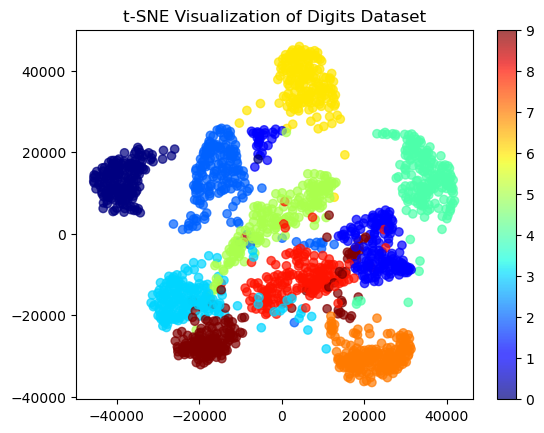

In [7]:
# Test the Implementation

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load dataset
digits = load_digits()
X = digits.data

# Run t-SNE
tsne = TSNE(n_iter=500)
Y = tsne.fit_transform(X)

# Plot the results
plt.scatter(Y[:, 0], Y[:, 1], c=digits.target, cmap="jet", alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of Digits Dataset")
plt.show()